In [1]:
import copy
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import datetime
import time
import joblib
from datetime import timedelta, date
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import os
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.api import qqplot
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error

import seaborn as sns;

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

import errno

from numpy import array

import tensorflow as tf
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

2022-11-04 15:45:31.598558: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# PATHS TO DATA OR RESULTS

data_path = "./Year data P//"
results_path = "./results//"



In [15]:
def rmse(pred, actual):
    return np.sqrt(((pred - actual) ** 2).mean())


def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def reshape_sequence(sequence, n_steps_in):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in

        # check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix,:-1]
        X.append(seq_x)

    return np.array(X)

In [16]:
from sklearn.model_selection import ShuffleSplit
rs = ShuffleSplit(n_splits=1, test_size=.25, random_state=0)

def shuffled_test_train(n_inp, n_out, sequence):
    batches = []
    for i in range(len(sequence)):
        if (i + n_inp + n_out > len(sequence)):
            break
        batches.append(sequence[i:i + n_inp + n_out])
  
    train = []
    test = []
    for train_index, test_index in rs.split(batches):
        print("TRAIN:", train_index, "TEST:", test_index)
    for i in train_index:
        train.append(batches[i])
    for i in test_index:
        test.append(batches[i])
    
    train = np.array(train)
    trainX = train[:,:n_inp,:-1]
    trainY = train[:,n_inp:,-1]
    test = np.array(test)
    testX = test[:,:n_inp,:-1]
    testY = test[:,n_inp:,-1]

    return train,test,trainX,trainY,testX,testY

In [17]:
def Plot_Mean(name,Overall_Analysis,n_steps_out):
    labels = ['TrainRMSE(Mean)','TestRMSE(Mean)']
    LSTM=[Overall_Analysis[0][4],Overall_Analysis[0][5]]
    CNN=[Overall_Analysis[1][4],Overall_Analysis[1][5]]
    Bi_LSTM=[Overall_Analysis[2][4],Overall_Analysis[2][5]]
    ED_LSTM=[Overall_Analysis[3][4],Overall_Analysis[3][5]]
    
    yer1=np.array([Overall_Analysis[0][3]-Overall_Analysis[0][0],Overall_Analysis[0][8]-Overall_Analysis[0][5]])
    yer2=np.array([Overall_Analysis[1][3]-Overall_Analysis[1][0],Overall_Analysis[1][8]-Overall_Analysis[1][5]])
    yer3=np.array([Overall_Analysis[2][3]-Overall_Analysis[2][0],Overall_Analysis[2][8]-Overall_Analysis[2][5]])
    yer4=np.array([Overall_Analysis[3][3]-Overall_Analysis[3][0],Overall_Analysis[3][8]-Overall_Analysis[3][5]])
    
    width = 0.12  # the width of the bars
    Plot(name,labels,width,LSTM,CNN,Bi_LSTM,ED_LSTM,yer1,yer2,yer3,yer4,"","","Train&Test_RMSE_Mean_Comparison",4)
    
    
def Plot_Best(name,Overall_Analysis,n_steps_out):
    labels = ['TrainRMSE(Best)','TestRMSE(Best)']
    LSTM=[Overall_Analysis[0][4],Overall_Analysis[0][9]]
    CNN=[Overall_Analysis[1][4],Overall_Analysis[1][9]]
    Bi_LSTM=[Overall_Analysis[2][4],Overall_Analysis[2][9]]
    ED_LSTM=[Overall_Analysis[3][4],Overall_Analysis[3][9]]
    
    yer1=np.array([Overall_Analysis[0][3]-Overall_Analysis[0][0],Overall_Analysis[0][8]-Overall_Analysis[0][5]])
    yer2=np.array([Overall_Analysis[1][3]-Overall_Analysis[1][0],Overall_Analysis[1][8]-Overall_Analysis[1][5]])
    yer3=np.array([Overall_Analysis[2][3]-Overall_Analysis[2][0],Overall_Analysis[2][8]-Overall_Analysis[2][5]])
    yer4=np.array([Overall_Analysis[3][3]-Overall_Analysis[3][0],Overall_Analysis[3][8]-Overall_Analysis[3][5]])
    
    width = 0.12  # the width of the bars
    Plot(name,labels,width,LSTM,CNN,Bi_LSTM,ED_LSTM,yer1,yer2,yer3,yer4,"","","Train&Test_RMSE_Comparison",4)

def Plot_Step_RMSE_Mean(name,Overall_Analysis,n_steps_out):
    
    LSTM=Overall_Analysis[0,10:n_steps_out*5+10:5]
    CNN=Overall_Analysis[1,10:n_steps_out*5+10:5]
    Bi_LSTM=Overall_Analysis[2,10:n_steps_out*5+10:5]
    ED_LSTM=Overall_Analysis[3,10:n_steps_out*5+10:5]
    yer1=np.subtract(Overall_Analysis[0,13:n_steps_out*5+10:5],LSTM)
    yer2=np.subtract(Overall_Analysis[1,13:n_steps_out*5+10:5],CNN)
    yer3=np.subtract(Overall_Analysis[2,13:n_steps_out*5+10:5],Bi_LSTM)
    yer4=np.subtract(Overall_Analysis[3,13:n_steps_out*5+10:5],ED_LSTM)
    labels = []
    for j in range(n_steps_out):
        labels=np.concatenate((labels,[str(j+1)]))
    width = 0.12  # the width of the bars
    Plot(name,labels,width,LSTM,CNN,Bi_LSTM,ED_LSTM,yer1,yer2,yer3,yer4,"Steps","RMSE(Mean)","Step_RMSE_Comparison",2)
    
    

def Plot(name,labels,width,LSTM,CNN,Bi_LSTM,ED_LSTM,yer1,yer2,yer3,yer4,xlabel,ylabel,Gname,cap):
    r1 = np.arange(len(labels))
    r2 = [x + width for x in r1]
    r3 = [x + width for x in r2]
    r4 = [x + width for x in r3]

    fig, ax = plt.subplots()
    rects1 = ax.bar(r1, LSTM, width,edgecolor = 'black', yerr=yer1, capsize=cap, label='LSTM')
    rects2 = ax.bar(r2, CNN, width,edgecolor = 'black', yerr=yer2,capsize=cap,  label='CNN')
    rects3 = ax.bar(r3, Bi_LSTM, width,edgecolor = 'black', yerr=yer3,capsize=cap,  label='Bi_LSTM')
    rects4 = ax.bar(r4, ED_LSTM, width,edgecolor = 'black', yerr=yer4,capsize=cap,  label='ED_LSTM')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks([r + width for r in range(len(LSTM))], labels)
    plt.setp(ax.get_xticklabels(), fontsize=8)
    ax.legend()
    fig.tight_layout()
    plt.savefig(results_path + name + "_" + Gname + "_shuffle53.png",dpi=300)
    plt.show()

In [18]:
def MULTI_MODEL_LSTM(x,x_train, x_test, y_train, y_test, Num_Exp, n_steps_in, n_steps_out, Epochs, Hidden):
    n_features = x_train.shape[2]
    x_features = x.shape[1]-1
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
    print(x_train.shape)
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))
    print(x_test.shape)
    x = reshape_sequence(x.values,n_steps_in)
    x = x.reshape((x.shape[0], x.shape[1], x_features))

    train_acc = np.zeros(Num_Exp)
    test_acc = np.zeros(Num_Exp)
    Step_RMSE = np.zeros([Num_Exp, n_steps_out])

    model = Sequential()
    model.add(LSTM(Hidden, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    Best_RMSE = 1000  # Assigning a large number

    start_time = time.time()
    for run in range(Num_Exp):
        print("Experiment", run + 1, "in progress")
        # fit model
        model.fit(x_train, y_train, epochs=Epochs, batch_size=64, verbose=0, shuffle=False)
        y_predicttrain = model.predict(x_train)
        y_predicttest = model.predict(x_test)
        y_predict = model.predict(x)
        train_acc[run] = rmse(y_predicttrain, y_train)
        test_acc[run] = rmse(y_predicttest, y_test)
        if test_acc[run] < Best_RMSE:
            Best_RMSE = test_acc[run]
            Best_Predict_Test = y_predicttest
            Best_Predict = y_predict
        for j in range(n_steps_out):
            Step_RMSE[run][j] = rmse(y_predicttest[:, j], y_test[:, j])
    #print('hh',Best_Predict)
    y = x[[-5,-4,-3, -2, -1], :]
    y = y.reshape((y.shape[0], y.shape[1], n_features))
    y1_predict=model.predict(y)
    Best_Predict=np.row_stack((Best_Predict,y1_predict))
    print(Best_Predict.shape)


    print("Total time for", Num_Exp, "experiments", time.time() - start_time)
    return train_acc, test_acc, Step_RMSE, Best_Predict_Test, Best_Predict

def MULTI_MODEL_ED_LSTM(x,x_train, x_test, y_train, y_test, Num_Exp, n_steps_in, n_steps_out, Epochs, Hidden):
    n_features = x_train.shape[2]
    x_features = x.shape[1]-1
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
    print(x_train.shape)
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))
    print(x_test.shape)
    x = reshape_sequence(x.values,n_steps_in)
    x = x.reshape((x.shape[0], x.shape[1], x_features))

    train_acc = np.zeros(Num_Exp)
    test_acc = np.zeros(Num_Exp)
    Step_RMSE = np.zeros([Num_Exp, n_steps_out])

    model = Sequential()
    model.add(LSTM(Hidden, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(RepeatVector(n_steps_out))
    model.add(LSTM(Hidden, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    Best_RMSE = 1000  # Assigning a large number

    start_time = time.time()
    for run in range(Num_Exp):
        print("Experiment", run + 1, "in progress")
        # fit model
        model.fit(x_train, y_train, epochs=Epochs, batch_size=64, verbose=0, shuffle=False)
        y_predicttrain = model.predict(x_train)
        y_predicttrain= np.squeeze(y_predicttrain, axis=(2,))
        y_predicttest = model.predict(x_test)
        y_predicttest= np.squeeze(y_predicttest, axis=(2,))
        y_predict = model.predict(x)
        
        train_acc[run] = rmse(y_predicttrain, y_train)
        test_acc[run] = rmse(y_predicttest, y_test)
        if test_acc[run] < Best_RMSE:
            Best_RMSE = test_acc[run]
            Best_Predict_Test = y_predicttest
            Best_Predict = y_predict
        for j in range(n_steps_out):
            Step_RMSE[run][j] = rmse(y_predicttest[:, j], y_test[:, j])
    #print('hh',Best_Predict)
    y = x[[-5,-4,-3, -2, -1], :]
    y = y.reshape((y.shape[0], y.shape[1], n_features))
    y1_predict=model.predict(y)
    Best_Predict=np.row_stack((Best_Predict,y1_predict))
    Best_Predict=np.squeeze(Best_Predict, axis=(2,))
    print(Best_Predict.shape)


    print("Total time for", Num_Exp, "experiments", time.time() - start_time)
    return train_acc, test_acc, Step_RMSE, Best_Predict_Test, Best_Predict

def MULTI_MODEL_CNN(x,x_train, x_test, y_train, y_test, Num_Exp, n_steps_in, n_steps_out, Epochs, Hidden):
    n_features = x_train.shape[2]
    x_features = x.shape[1]-1
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
    print(x_train.shape)
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))
    print(x_test.shape)
    x = reshape_sequence(x.values,n_steps_in)
    x = x.reshape((x.shape[0], x.shape[1], x_features))

    train_acc = np.zeros(Num_Exp)
    test_acc = np.zeros(Num_Exp)
    Step_RMSE = np.zeros([Num_Exp, n_steps_out])

    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(Hidden, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    Best_RMSE = 1000  # Assigning a large number

    start_time = time.time()
    for run in range(Num_Exp):
        print("Experiment", run + 1, "in progress")
        # fit model
        model.fit(x_train, y_train, epochs=Epochs, batch_size=64, verbose=0, shuffle=False)
        y_predicttrain = model.predict(x_train)
        y_predicttest = model.predict(x_test)
        y_predict = model.predict(x)
        train_acc[run] = rmse(y_predicttrain, y_train)
        test_acc[run] = rmse(y_predicttest, y_test)
        if test_acc[run] < Best_RMSE:
            Best_RMSE = test_acc[run]
            Best_Predict_Test = y_predicttest
            Best_Predict = y_predict
        for j in range(n_steps_out):
            Step_RMSE[run][j] = rmse(y_predicttest[:, j], y_test[:, j])
    #print('hh',Best_Predict)
    y = x[[-5,-4,-3, -2, -1], :]
    y = y.reshape((y.shape[0], y.shape[1], n_features))
    y1_predict=model.predict(y)
    Best_Predict=np.row_stack((Best_Predict,y1_predict))
    print(Best_Predict.shape)


    print("Total time for", Num_Exp, "experiments", time.time() - start_time)
    return train_acc, test_acc, Step_RMSE, Best_Predict_Test, Best_Predict

def MULTI_MODEL_Bi_LSTM(x,x_train, x_test, y_train, y_test, Num_Exp, n_steps_in, n_steps_out, Epochs, Hidden):
    n_features = x_train.shape[2]
    x_features = x.shape[1]-1
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
    print(x_train.shape)
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))
    print(x_test.shape)
    x = reshape_sequence(x.values,n_steps_in)
    x = x.reshape((x.shape[0], x.shape[1], x_features))

    train_acc = np.zeros(Num_Exp)
    test_acc = np.zeros(Num_Exp)
    Step_RMSE = np.zeros([Num_Exp, n_steps_out])

    model = Sequential()
    #model.add(LSTM(Hidden, return_sequences=True,activation='relu', input_shape=(n_steps_in, n_features)))
    #model.add(LSTM(Hidden, activation='relu'))
    model.add(Bidirectional(LSTM(Hidden, activation='relu'), input_shape=(n_steps_in, n_features)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    Best_RMSE = 1000  # Assigning a large number

    start_time = time.time()
    for run in range(Num_Exp):
        print("Experiment", run + 1, "in progress")
        # fit model
        model.fit(x_train, y_train, epochs=Epochs, batch_size=64, verbose=0, shuffle=False)
        y_predicttrain = model.predict(x_train)
        y_predicttest = model.predict(x_test)
        y_predict = model.predict(x)
        train_acc[run] = rmse(y_predicttrain, y_train)
        test_acc[run] = rmse(y_predicttest, y_test)
        if test_acc[run] < Best_RMSE:
            Best_RMSE = test_acc[run]
            Best_Predict_Test = y_predicttest
            Best_Predict = y_predict
        for j in range(n_steps_out):
            Step_RMSE[run][j] = rmse(y_predicttest[:, j], y_test[:, j])
    #print('hh',Best_Predict)
    y = x[[-5,-4,-3, -2, -1], :]
    y = y.reshape((y.shape[0], y.shape[1], n_features))
    y1_predict=model.predict(y)
    Best_Predict=np.row_stack((Best_Predict,y1_predict))
    print(Best_Predict.shape)


    print("Total time for", Num_Exp, "experiments", time.time() - start_time)
    return train_acc, test_acc, Step_RMSE, Best_Predict_Test, Best_Predict

In [19]:
#Estimates_data = data['2021':'2026']


def main():
    
    n_steps_in, n_steps_out = 5,3
    Overall_Analysis=np.zeros([52,10+n_steps_out*5])
    
    for i in range(1,14):
        Country=i
        if Country==1:
            df = pd.read_csv(data_path + 'Australia//Australia data3.csv')
            df = df.loc[df['year'] >= 1980]
            
            df = df.drop(['countrycode','country','currency_unit','year'],axis = 1)
            year = pd.period_range('1980', '2019', freq='Y')
            df.index = year


            data = df
            #Scaler
    
            Xscaler =MinMaxScaler()
            data.iloc[:,0:-1]=Xscaler.fit_transform(data.values[:,0:-1])
    
            Yscaler = MinMaxScaler()
            Yscaled=Yscaler.fit_transform(data.values[:,-1].reshape(-1,1))
            data.iloc[:,-1] = Yscaled.reshape(-1,)
    
            TrainData = data['1980':'2010'].values
            TestData = data['2011':'2019'].values
            name = "Australia"
            
        if Country==2:
            df = pd.read_csv(data_path + 'Brazil//Brazil Data.csv')
            df = df.loc[df['year'] >= 1980]
            df = df.drop(['countrycode','country','currency_unit','year'],axis = 1)
            year = pd.period_range('1980', '2019', freq='Y')
            df.index = year

            data = df
            #Scaler
    
            Xscaler =MinMaxScaler()
            data.iloc[:,0:-1]=Xscaler.fit_transform(data.values[:,0:-1])
    
            Yscaler = MinMaxScaler()
            Yscaled=Yscaler.fit_transform(data.values[:,-1].reshape(-1,1))
            data.iloc[:,-1] = Yscaled.reshape(-1,)
    
            TrainData = data['1980':'2010'].values
            TestData = data['2011':'2019'].values
            name = "Brazil"
            
        if Country==3:
            df = pd.read_csv(data_path + 'Canada//Canada Data.csv')
            df = df.loc[df['year'] >= 1980]
            df = df.drop(['countrycode','country','currency_unit','year'],axis = 1)
            year = pd.period_range('1980', '2019', freq='Y')
            df.index = year


            data = df
            #Scaler
    
            Xscaler =MinMaxScaler()
            data.iloc[:,0:-1]=Xscaler.fit_transform(data.values[:,0:-1])
    
            Yscaler = MinMaxScaler()
            Yscaled=Yscaler.fit_transform(data.values[:,-1].reshape(-1,1))
            data.iloc[:,-1] = Yscaled.reshape(-1,)
    
            TrainData = data['1980':'2010'].values
            TestData = data['2011':'2019'].values
            name = "Canada"
            
        if Country==4:
            df = pd.read_csv(data_path + 'China//China Data.csv')
            df = df.loc[df['year'] >= 1980]
            df = df.drop(['countrycode','country','currency_unit','year'],axis = 1)
            year = pd.period_range('1980', '2019', freq='Y')
            df.index = year


            data = df
            #Scaler
    
            Xscaler =MinMaxScaler()
            data.iloc[:,0:-1]=Xscaler.fit_transform(data.values[:,0:-1])
    
            Yscaler = MinMaxScaler()
            Yscaled=Yscaler.fit_transform(data.values[:,-1].reshape(-1,1))
            data.iloc[:,-1] = Yscaled.reshape(-1,)
    
            TrainData = data['1980':'2010'].values
            TestData = data['2011':'2019'].values
            name = "China"
            
        if Country==5:
            df = pd.read_csv(data_path + 'France//France Data.csv')
            df = df.loc[df['year'] >= 1980]
            df = df.drop(['countrycode','country','currency_unit','year'],axis = 1)
            year = pd.period_range('1980', '2019', freq='Y')
            df.index = year


            data = df
            #Scaler
    
            Xscaler =MinMaxScaler()
            data.iloc[:,0:-1]=Xscaler.fit_transform(data.values[:,0:-1])
    
            Yscaler = MinMaxScaler()
            Yscaled=Yscaler.fit_transform(data.values[:,-1].reshape(-1,1))
            data.iloc[:,-1] = Yscaled.reshape(-1,)
    
            TrainData = data['1980':'2010'].values
            TestData = data['2011':'2019'].values
            name = "France"
            
        if Country==6:
            df = pd.read_csv(data_path + 'Germany//Germany Data.csv')
            df = df.loc[df['year'] >= 1980]
            df = df.drop(['countrycode','country','currency_unit','year'],axis = 1)
            year = pd.period_range('1980', '2019', freq='Y')
            df.index = year


            data = df
            #Scaler
    
            Xscaler =MinMaxScaler()
            data.iloc[:,0:-1]=Xscaler.fit_transform(data.values[:,0:-1])
    
            Yscaler = MinMaxScaler()
            Yscaled=Yscaler.fit_transform(data.values[:,-1].reshape(-1,1))
            data.iloc[:,-1] = Yscaled.reshape(-1,)
    
            TrainData = data['1980':'2010'].values
            TestData = data['2011':'2019'].values
            name = "Germany"
            
        if Country==7:
            df = pd.read_csv(data_path + 'India//India Data.csv')
            df = df.loc[df['year'] >= 1980]
            df = df.drop(['countrycode','country','currency_unit','year'],axis = 1)
            year = pd.period_range('1980', '2019', freq='Y')
            df.index = year


            data = df
            #Scaler
    
            Xscaler =MinMaxScaler()
            data.iloc[:,0:-1]=Xscaler.fit_transform(data.values[:,0:-1])
    
            Yscaler = MinMaxScaler()
            Yscaled=Yscaler.fit_transform(data.values[:,-1].reshape(-1,1))
            data.iloc[:,-1] = Yscaled.reshape(-1,)
    
            TrainData = data['1980':'2010'].values
            TestData = data['2011':'2019'].values
            name = "India"
            
        if Country==8:
            df = pd.read_csv(data_path + 'Italy//Italy Data.csv')
            df = df.loc[df['year'] >= 1980]
            df = df.drop(['countrycode','country','currency_unit','year'],axis = 1)
            year = pd.period_range('1980', '2019', freq='Y')
            df.index = year


            data = df
            #Scaler
    
            Xscaler =MinMaxScaler()
            data.iloc[:,0:-1]=Xscaler.fit_transform(data.values[:,0:-1])
    
            Yscaler = MinMaxScaler()
            Yscaled=Yscaler.fit_transform(data.values[:,-1].reshape(-1,1))
            data.iloc[:,-1] = Yscaled.reshape(-1,)
    
            TrainData = data['1980':'2010'].values
            TestData = data['2011':'2019'].values
            name = "Italy"
            
        if Country==9:
            df = pd.read_csv(data_path + 'Japan//Japan Data.csv')
            df = df.loc[df['year'] >= 1980]
            df = df.drop(['countrycode','country','currency_unit','year'],axis = 1)
            year = pd.period_range('1980', '2019', freq='Y')
            df.index = year


            data = df
            #Scaler
    
            Xscaler =MinMaxScaler()
            data.iloc[:,0:-1]=Xscaler.fit_transform(data.values[:,0:-1])
    
            Yscaler = MinMaxScaler()
            Yscaled=Yscaler.fit_transform(data.values[:,-1].reshape(-1,1))
            data.iloc[:,-1] = Yscaled.reshape(-1,)
    
            TrainData = data['1980':'2010'].values
            TestData = data['2011':'2019'].values
            name = "Japan"
            
        if Country==10:
            df = pd.read_csv(data_path + 'Russia//Russia Data.csv')
            df = df.loc[df['year'] >= 1991]
            df = df.drop(['countrycode','country','currency_unit','year'],axis = 1)
            year = pd.period_range('1991', '2019', freq='Y')
            df.index = year


            data = df
            #Scaler
    
            Xscaler =MinMaxScaler()
            data.iloc[:,0:-1]=Xscaler.fit_transform(data.values[:,0:-1])
    
            Yscaler = MinMaxScaler()
            Yscaled=Yscaler.fit_transform(data.values[:,-1].reshape(-1,1))
            data.iloc[:,-1] = Yscaled.reshape(-1,)
    
            TrainData = data['1991':'2010'].values
            TestData = data['2011':'2019'].values
            name = "Russia"
            
        if Country==11:
            df = pd.read_csv(data_path + 'South Africa//South Africa Data.csv')
            df = df.loc[df['year'] >= 1980]
            df = df.drop(['countrycode','country','currency_unit','year'],axis = 1)
            year = pd.period_range('1980', '2019', freq='Y')
            df.index = year


            data = df
            #Scaler
    
            Xscaler =MinMaxScaler()
            data.iloc[:,0:-1]=Xscaler.fit_transform(data.values[:,0:-1])
    
            Yscaler = MinMaxScaler()
            Yscaled=Yscaler.fit_transform(data.values[:,-1].reshape(-1,1))
            data.iloc[:,-1] = Yscaled.reshape(-1,)
    
            TrainData = data['1980':'2010'].values
            TestData = data['2011':'2019'].values
            name = "South Africa"
            
        if Country==12:
            df = pd.read_csv(data_path + 'United Kingdom//United Kingdom Data.csv')
            df = df.loc[df['year'] >= 1980]
            df = df.drop(['countrycode','country','currency_unit','year'],axis = 1)
            year = pd.period_range('1980', '2019', freq='Y')
            df.index = year


            data = df
            #Scaler
    
            Xscaler =MinMaxScaler()
            data.iloc[:,0:-1]=Xscaler.fit_transform(data.values[:,0:-1])
    
            Yscaler = MinMaxScaler()
            Yscaled=Yscaler.fit_transform(data.values[:,-1].reshape(-1,1))
            data.iloc[:,-1] = Yscaled.reshape(-1,)
    
            TrainData = data['1980':'2010'].values
            TestData = data['2011':'2019'].values
            name = "United Kingdom"
            
        if Country==13:
            df = pd.read_csv(data_path + 'United States//United States Data.csv')
            df = df.loc[df['year'] >= 1980]
            df = df.drop(['countrycode','country','currency_unit','year'],axis = 1)
            year = pd.period_range('1980', '2019', freq='Y')
            df.index = year


            data = df
            #Scaler
    
            Xscaler =MinMaxScaler()
            data.iloc[:,0:-1]=Xscaler.fit_transform(data.values[:,0:-1])
    
            Yscaler = MinMaxScaler()
            Yscaled=Yscaler.fit_transform(data.values[:,-1].reshape(-1,1))
            data.iloc[:,-1] = Yscaled.reshape(-1,)
    
            TrainData = data['1980':'2010'].values
            TestData = data['2011':'2019'].values
            name = "United States"
            
       
    
        #x_train, y_train = split_sequences(TrainData, n_steps_in, n_steps_out)
        #x_test, y_test = split_sequences(TestData, n_steps_in, n_steps_out)
        
        train,test,x_train,y_train,x_test,y_test = shuffled_test_train(n_steps_in,n_steps_out,data)
        
        print(name)
        Num_Exp=30
        Epochs= 500
        Hidden= 10
        train_acc = np.zeros(Num_Exp)
        test_acc = np.zeros(Num_Exp)
        Step_RMSE = np.zeros([Num_Exp, n_steps_out])
   
   
        
        for k in range(1,5):
            method = k
            if method == 1:
                train_acc, test_acc, Step_RMSE, Best_Predict_Test, Best_Predict = MULTI_MODEL_LSTM(data,x_train, x_test, y_train, y_test, Num_Exp,n_steps_in, n_steps_out, Epochs, Hidden)
                Mname = 'MODEL_LSTM'
            if method == 2:
                train_acc, test_acc, Step_RMSE, Best_Predict_Test, Best_Predict = MULTI_MODEL_CNN(data,x_train, x_test, y_train, y_test, Num_Exp,n_steps_in, n_steps_out, Epochs, Hidden)
                Mname = 'MODEL_CNN'
            if method == 3:
                train_acc, test_acc, Step_RMSE, Best_Predict_Test, Best_Predict = MULTI_MODEL_Bi_LSTM(data,x_train, x_test, y_train, y_test, Num_Exp,n_steps_in, n_steps_out, Epochs, Hidden)
                Mname = 'Bi_LSTM'
            if method == 4:
                train_acc, test_acc, Step_RMSE, Best_Predict_Test, Best_Predict =MULTI_MODEL_ED_LSTM(data,x_train, x_test, y_train, y_test, Num_Exp,n_steps_in, n_steps_out, Epochs, Hidden)
                Mname = 'ED_LSTM'
            print(Mname)
            
            arr = np.dstack((train_acc,test_acc))
            arr=arr.reshape(Num_Exp,2)
            arr=np.concatenate((arr,Step_RMSE), axis=1)
            arr=arr.reshape(Num_Exp,2+n_steps_out)
            
            
            ExpIndex=np.array([])
            for j in range(Num_Exp):
                ExpIndex=np.concatenate((ExpIndex,["Exp"+str(j+1)]))

            ExpIndex1=['TrainRMSE','TestRMSE']
            for j in range(n_steps_out):
                ExpIndex1=np.concatenate((ExpIndex1,["Step"+str(j+1)]))
                
            arr=np.round_(arr, decimals = 5) 
            arr = pd.DataFrame(arr, index = ExpIndex , columns = ExpIndex1)
            arr.to_csv( results_path + name + "_" + Mname + "_ExpAnalysis.csv")
            #print(arr)
            
            Train_Best=rmse(TrainData[5:,-1],Best_Predict[:-15, 0])
        
            Test_Best=rmse(TestData[:,-1],Best_Predict[-15:-6, 0])
            
            Train_Mean=np.mean(train_acc)
            Train_Std=np.std(train_acc)
            Train_CI_LB= Train_Mean-1.96*(Train_Std/np.sqrt(Num_Exp))
            Train_CI_UB= Train_Mean+1.96*(Train_Std/np.sqrt(Num_Exp))
        
            Test_Mean=np.mean(test_acc)
            Test_Std=np.std(test_acc)
            Test_CI_LB= Test_Mean-1.96*(Test_Std/np.sqrt(Num_Exp))
            Test_CI_UB= Test_Mean+1.96*(Test_Std/np.sqrt(Num_Exp))
            
            Overall_Analysis[(i-1)*4+(k-1)][0]=Train_Mean
            Overall_Analysis[(i-1)*4+(k-1)][1]=Train_Std
            Overall_Analysis[(i-1)*4+(k-1)][2]=Train_CI_LB
            Overall_Analysis[(i-1)*4+(k-1)][3]=Train_CI_UB                
            Overall_Analysis[(i-1)*4+(k-1)][4]=Train_Best
            Overall_Analysis[(i-1)*4+(k-1)][5]=Test_Mean
            Overall_Analysis[(i-1)*4+(k-1)][6]=Test_Std
            Overall_Analysis[(i-1)*4+(k-1)][7]=Test_CI_LB
            Overall_Analysis[(i-1)*4+(k-1)][8]=Test_CI_UB
            Overall_Analysis[(i-1)*4+(k-1)][9]=Test_Best
            
            arr1 = np.vstack(([Train_Mean,Train_Std,Train_CI_LB,Train_CI_UB,np.min(train_acc),np.max(train_acc)],[Test_Mean,Test_Std,Test_CI_LB,Test_CI_UB,np.min(test_acc),np.max(test_acc)]))
          
            for j in range(n_steps_out):
                Step_mean = np.mean(Step_RMSE[:,j])
                Step_std = np.std(Step_RMSE[:,j])
                Step_min = np.min(Step_RMSE[:,j])
                Step_CI_LB= Step_mean-1.96*(Step_std/np.sqrt(Num_Exp))
                Step_CI_UB= Step_mean+1.96*(Step_std/np.sqrt(Num_Exp))
                arr1=np.vstack((arr1,[Step_mean,Step_std,Step_CI_LB,Step_CI_UB,Step_min,np.max(Step_RMSE[:,j])]))
                Overall_Analysis[(i-1)*4+(k-1)][5*j+10]= Step_mean
                Overall_Analysis[(i-1)*4+(k-1)][5*j+11]= Step_std
                Overall_Analysis[(i-1)*4+(k-1)][5*j+12]= Step_CI_LB
                Overall_Analysis[(i-1)*4+(k-1)][5*j+13]= Step_CI_UB
                Overall_Analysis[(i-1)*4+(k-1)][5*j+14]= Step_min
            arr1=np.round_(arr1, decimals = 5) 
            arr1 = pd.DataFrame(arr1, index=ExpIndex1, columns = ['Mean','Standard Deviation','CI_LB','CI_UB','Min','Max'])
            #print(arr1)
            #arr1.to_csv("D://project data//Year data//"+name+"/"+Mname+"OverallAnalysis.csv")
            
            x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
            #for j in range(n_steps_out):
             #   plt.figure()
              #  plt.plot(x_data, y_test[:,j], label='actual')
              # plt.plot(x_data, Best_Predict_Test[:,j], label='predicted')
              #  plt.ylabel('RMSE')  
              #  plt.xlabel('Time (samples)') 
              #  plt.title('Actual vs Predicted')
              #  plt.legend()
              #  #plt.savefig("D://project data//Year data//"+name+"/"+Mname+'pred_Step'+str(j+1)+'.png',dpi=300) 
              # plt.show()
              #  plt.close()
            
            print(rmse(TrainData[5:,-1],Best_Predict[:-15, 0]))
            print(rmse(TestData[:,-1],Best_Predict[-15:-6, 0]))
            
            Best_Predict  = Best_Predict[:,0]
            #np.row_stack((Best_Predict[:-5,0],Best_Predict[-5,:]))
            
            Best_Predict = Yscaler.inverse_transform(Best_Predict.reshape(-1,1))            
            
            if Country==10:
                data1 = Yscaler.inverse_transform(data.values[:,-1].reshape(-1,1))
                data_list = map(lambda x: x[0], data1)
                data1 = pd.Series(data_list)
                year = pd.period_range('1991', '2019', freq='Y')
                data1.index = year
                
                year_1 = pd.period_range('1996', '2025', freq='Y')
            else:
                data1 = Yscaler.inverse_transform(data.values[:,-1].reshape(-1,1))
                data_list = map(lambda x: x[0], data1)
                data1 = pd.Series(data_list)
                year = pd.period_range('1980', '2019', freq='Y')
                data1.index = year
                
                year_1 = pd.period_range('1985', '2025', freq='Y')
            
            d = list(Best_Predict)
            print(year_1.shape)
          
            plt.figure()
            data1.plot(label = 'GDP')
            plt.xlim(['1980','2031'])
            plt.plot(year_1, d, label= Mname)
            plt.ylabel('GDP Growth(%)')
            plt.xlabel('Year')
            plt.title(name+ 'Actual vs Predicted')
            plt.legend()
            plt.savefig( results_path + name + "_" + Mname  + '_shuffle53.png', dpi=300)
            plt.show()
            plt.close()
            plt.figure()
            
            #Plot mean of train_RMSE and test_RMSE
            #Plot Std of train_RMSE and test_RMSE
        Plot_Mean(name,Overall_Analysis[4*(i-1):(4*i),:],n_steps_out)
        Plot_Best(name,Overall_Analysis[4*(i-1):(4*i),:],n_steps_out)
            #Plot Step wise RMSE mean for different methods
        Plot_Step_RMSE_Mean(name,Overall_Analysis[4*(i-1):(4*i),:],n_steps_out)
         
    Overall_Analysis=Overall_Analysis.astype('float64')
    Overall_Analysis=np.round_(Overall_Analysis, decimals = 4)  
    Index1=[]
    for j in range(1,14):
        Index1=np.concatenate((Index1, ['LSTM','CNN','BI_LSTM','ED_LSTM']))
        
    Index2=["Australia","Brazil","Canada","China","France","Germany","India","Italy","Japan","Russia","South Africa","United Kingdom","United States"]
    Index2=np.repeat(Index2,4)
    Index=np.dstack((Index2,Index1))
    Index=Index.reshape(52,2)
    Column=['Dataset','Method','Train-RMSE-Mean','Train-RMSE-Std','Train-CI-LB','Train-CI-UB','TrainRMSE-Best','Test-RMSE-Mean','Test-RMSE-Std','Test-CI-LB','Test-CI-UB','Test-RMSE-Best']
    for j in range(1,4):
        Column=np.concatenate((Column, ['Step'+str(j)+'-RMSE-Mean','Step'+str(j)+'-RMSE-Std','Step'+str(j)+'-CI-LB','Step'+str(j)+'-CI-UB','Step'+str(j)+'-RMSE-Min']))
  
    Overall_Analysis=np.concatenate((Index,Overall_Analysis), axis=1)
    Overall_Analysis = pd.DataFrame(Overall_Analysis, columns = Column)
    print(Overall_Analysis)
    Overall_Analysis.to_csv(results_path + "OverallAnalysis_raw_shuffled53.csv")

TRAIN: [32 29 23 15  8 13 30  5 14 28 22  1 12  6  4 18 21 19  9  7 31 27  3  0] TEST: [11 20 24 17  2 25 26 16 10]
Australia
(24, 5, 20)
(9, 5, 20)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 10)                1240      
                                                                 
 dense_27 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,273
Trainable params: 1,273
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 4ms/step
Experiment 4 in progress
2/2 [==============================] - 0s 2ms

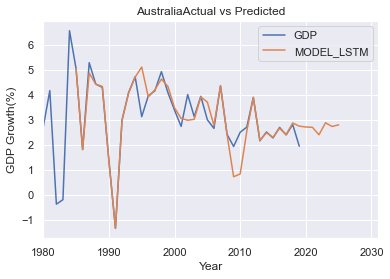

(24, 5, 20)
(9, 5, 20)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 4, 64)             2624      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 10)                1290      
                                                                 
 dense_29 (Dense)            (None, 3)                 33        
                                                                 
Total params: 3,947
Trainable params: 3,947
Non-trainable params: 0
____________________________

<Figure size 432x288 with 0 Axes>

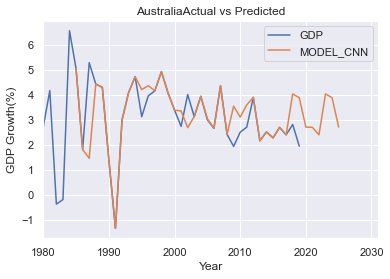

(24, 5, 20)
(9, 5, 20)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 20)               2480      
 nal)                                                            
                                                                 
 dense_30 (Dense)            (None, 3)                 63        
                                                                 
Total params: 2,543
Trainable params: 2,543
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 5 in progress
2/2 [========================

<Figure size 432x288 with 0 Axes>

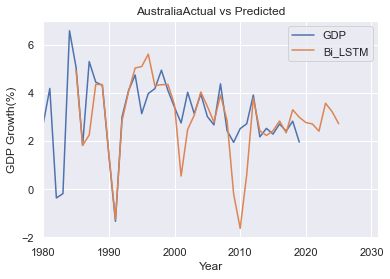

(24, 5, 20)
(9, 5, 20)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 10)                1240      
                                                                 
 repeat_vector_5 (RepeatVect  (None, 3, 10)            0         
 or)                                                             
                                                                 
 lstm_25 (LSTM)              (None, 3, 10)             840       
                                                                 
 time_distributed_5 (TimeDis  (None, 3, 1)             11        
 tributed)                                                       
                                                                 
Total params: 2,091
Trainable params: 2,091
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2

<Figure size 432x288 with 0 Axes>

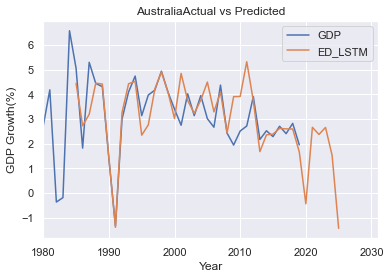

<Figure size 432x288 with 0 Axes>

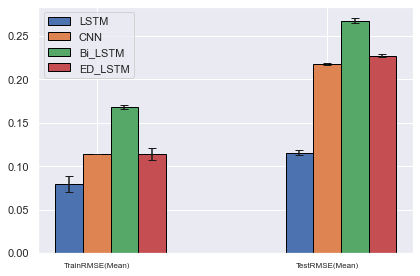

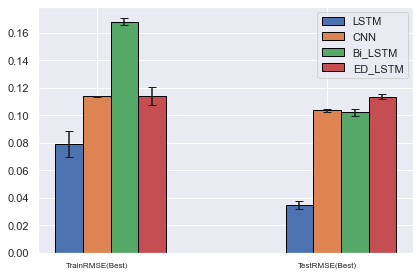

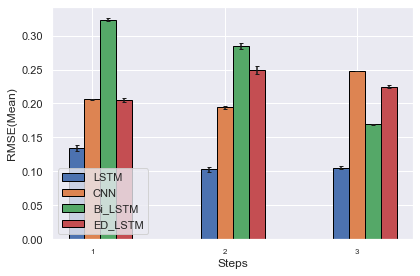

TRAIN: [32 29 23 15  8 13 30  5 14 28 22  1 12  6  4 18 21 19  9  7 31 27  3  0] TEST: [11 20 24 17  2 25 26 16 10]
Brazil
(24, 5, 20)
(9, 5, 20)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 10)                1240      
                                                                 
 dense_32 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,273
Trainable params: 1,273
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0s 2ms/st

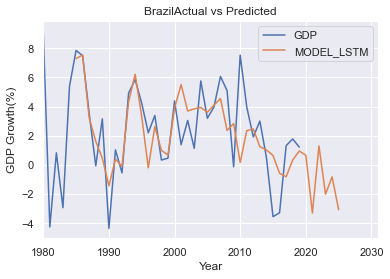

(24, 5, 20)
(9, 5, 20)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 4, 64)             2624      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 128)               0         
                                                                 
 dense_33 (Dense)            (None, 10)                1290      
                                                                 
 dense_34 (Dense)            (None, 3)                 33        
                                                                 
Total params: 3,947
Trainable params: 3,947
Non-trainable params: 0
____________________________

<Figure size 432x288 with 0 Axes>

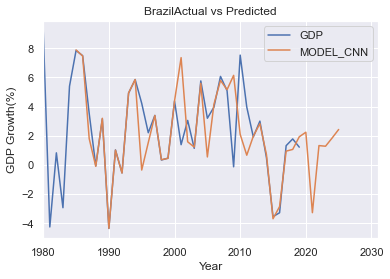

(24, 5, 20)
(9, 5, 20)
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 20)               2480      
 nal)                                                            
                                                                 
 dense_35 (Dense)            (None, 3)                 63        
                                                                 
Total params: 2,543
Trainable params: 2,543
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 5 in progress
2/2 [========================

<Figure size 432x288 with 0 Axes>

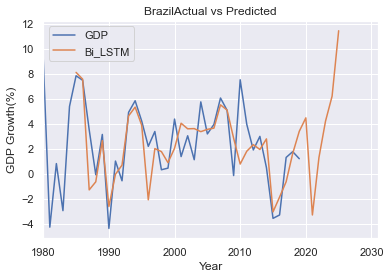

(24, 5, 20)
(9, 5, 20)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 10)                1240      
                                                                 
 repeat_vector_6 (RepeatVect  (None, 3, 10)            0         
 or)                                                             
                                                                 
 lstm_29 (LSTM)              (None, 3, 10)             840       
                                                                 
 time_distributed_6 (TimeDis  (None, 3, 1)             11        
 tributed)                                                       
                                                                 
Total params: 2,091
Trainable params: 2,091
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2

<Figure size 432x288 with 0 Axes>

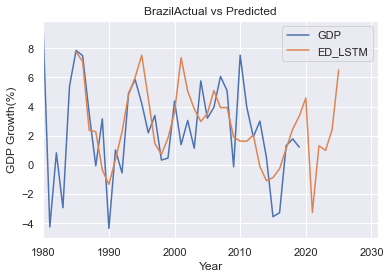

<Figure size 432x288 with 0 Axes>

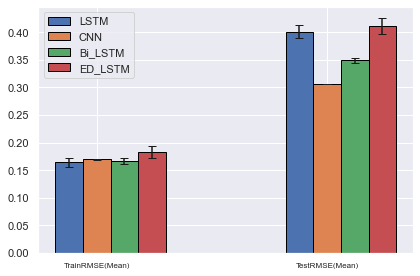

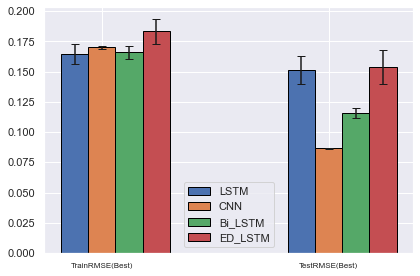

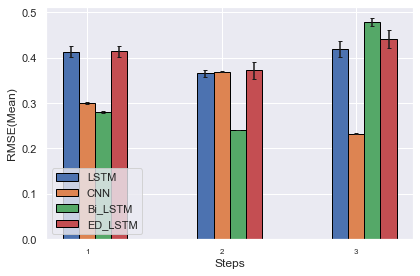

TRAIN: [32 29 23 15  8 13 30  5 14 28 22  1 12  6  4 18 21 19  9  7 31 27  3  0] TEST: [11 20 24 17  2 25 26 16 10]
Canada
(24, 5, 20)
(9, 5, 20)
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 10)                1240      
                                                                 
 dense_37 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,273
Trainable params: 1,273
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0s 2ms/st

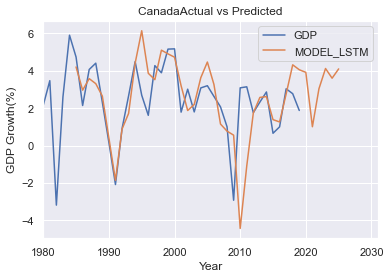

(24, 5, 20)
(9, 5, 20)
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 4, 64)             2624      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 128)               0         
                                                                 
 dense_38 (Dense)            (None, 10)                1290      
                                                                 
 dense_39 (Dense)            (None, 3)                 33        
                                                                 
Total params: 3,947
Trainable params: 3,947
Non-trainable params: 0
____________________________

<Figure size 432x288 with 0 Axes>

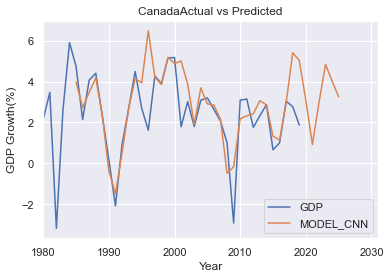

(24, 5, 20)
(9, 5, 20)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirectio  (None, 20)               2480      
 nal)                                                            
                                                                 
 dense_40 (Dense)            (None, 3)                 63        
                                                                 
Total params: 2,543
Trainable params: 2,543
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 4ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 5 in progress
2/2 [========================

<Figure size 432x288 with 0 Axes>

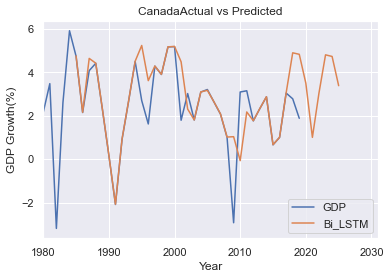

(24, 5, 20)
(9, 5, 20)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 10)                1240      
                                                                 
 repeat_vector_7 (RepeatVect  (None, 3, 10)            0         
 or)                                                             
                                                                 
 lstm_33 (LSTM)              (None, 3, 10)             840       
                                                                 
 time_distributed_7 (TimeDis  (None, 3, 1)             11        
 tributed)                                                       
                                                                 
Total params: 2,091
Trainable params: 2,091
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2

<Figure size 432x288 with 0 Axes>

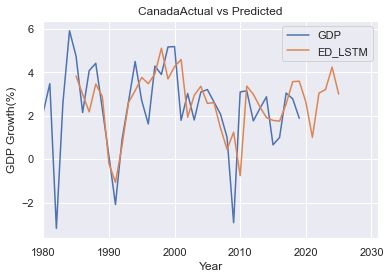

<Figure size 432x288 with 0 Axes>

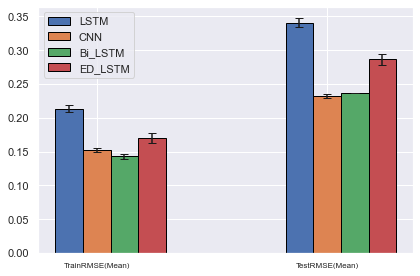

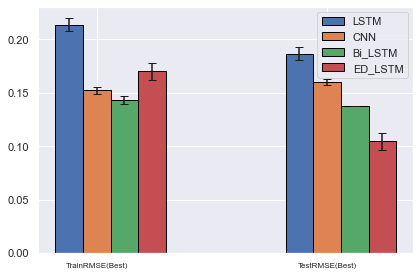

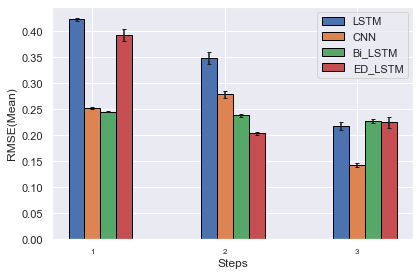

TRAIN: [32 29 23 15  8 13 30  5 14 28 22  1 12  6  4 18 21 19  9  7 31 27  3  0] TEST: [11 20 24 17  2 25 26 16 10]
China
(24, 5, 20)
(9, 5, 20)
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 10)                1240      
                                                                 
 dense_42 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,273
Trainable params: 1,273
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0s 2ms/ste

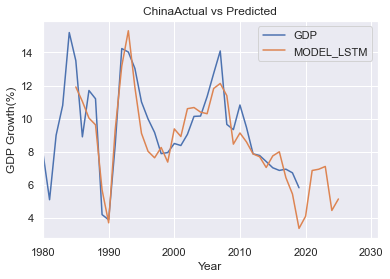

(24, 5, 20)
(9, 5, 20)
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 4, 64)             2624      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 128)               0         
                                                                 
 dense_43 (Dense)            (None, 10)                1290      
                                                                 
 dense_44 (Dense)            (None, 3)                 33        
                                                                 
Total params: 3,947
Trainable params: 3,947
Non-trainable params: 0
____________________________

<Figure size 432x288 with 0 Axes>

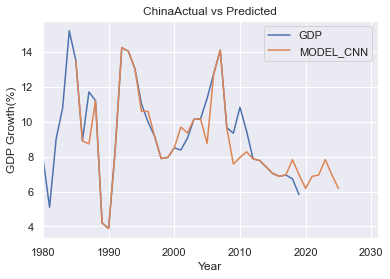

(24, 5, 20)
(9, 5, 20)
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 20)               2480      
 nal)                                                            
                                                                 
 dense_45 (Dense)            (None, 3)                 63        
                                                                 
Total params: 2,543
Trainable params: 2,543
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 3ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 5 in progress
2/2 [========================

<Figure size 432x288 with 0 Axes>

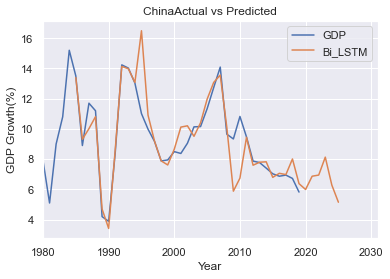

(24, 5, 20)
(9, 5, 20)
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 10)                1240      
                                                                 
 repeat_vector_8 (RepeatVect  (None, 3, 10)            0         
 or)                                                             
                                                                 
 lstm_37 (LSTM)              (None, 3, 10)             840       
                                                                 
 time_distributed_8 (TimeDis  (None, 3, 1)             11        
 tributed)                                                       
                                                                 
Total params: 2,091
Trainable params: 2,091
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2

<Figure size 432x288 with 0 Axes>

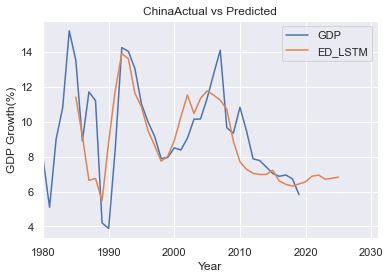

<Figure size 432x288 with 0 Axes>

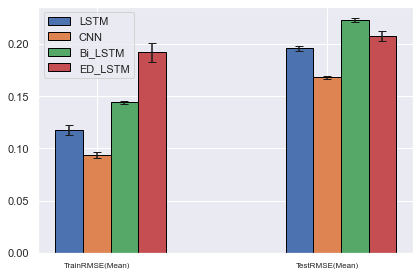

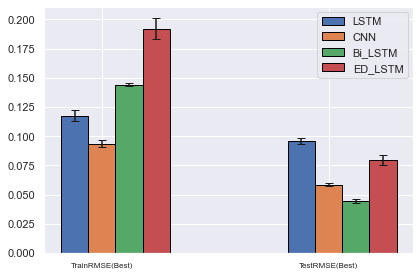

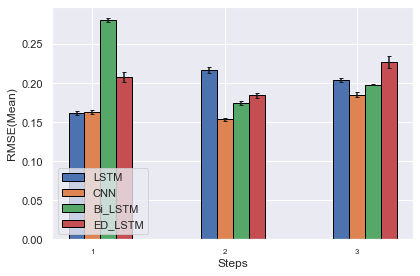

TRAIN: [32 29 23 15  8 13 30  5 14 28 22  1 12  6  4 18 21 19  9  7 31 27  3  0] TEST: [11 20 24 17  2 25 26 16 10]
France
(24, 5, 20)
(9, 5, 20)
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 10)                1240      
                                                                 
 dense_47 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,273
Trainable params: 1,273
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0s 2ms/st

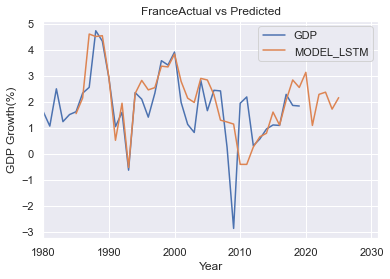

(24, 5, 20)
(9, 5, 20)
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 4, 64)             2624      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 128)               0         
                                                                 
 dense_48 (Dense)            (None, 10)                1290      
                                                                 
 dense_49 (Dense)            (None, 3)                 33        
                                                                 
Total params: 3,947
Trainable params: 3,947
Non-trainable params: 0
____________________________

<Figure size 432x288 with 0 Axes>

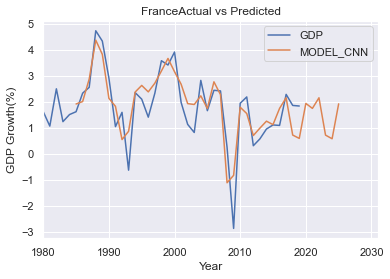

(24, 5, 20)
(9, 5, 20)
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirectio  (None, 20)               2480      
 nal)                                                            
                                                                 
 dense_50 (Dense)            (None, 3)                 63        
                                                                 
Total params: 2,543
Trainable params: 2,543
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 5 in progress
2/2 [========================

<Figure size 432x288 with 0 Axes>

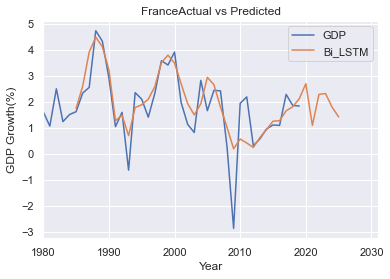

(24, 5, 20)
(9, 5, 20)
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 10)                1240      
                                                                 
 repeat_vector_9 (RepeatVect  (None, 3, 10)            0         
 or)                                                             
                                                                 
 lstm_41 (LSTM)              (None, 3, 10)             840       
                                                                 
 time_distributed_9 (TimeDis  (None, 3, 1)             11        
 tributed)                                                       
                                                                 
Total params: 2,091
Trainable params: 2,091
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2

<Figure size 432x288 with 0 Axes>

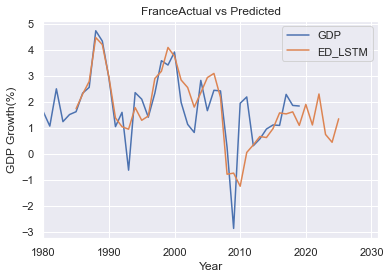

<Figure size 432x288 with 0 Axes>

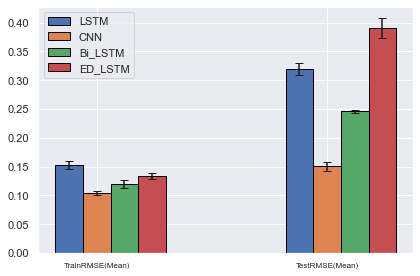

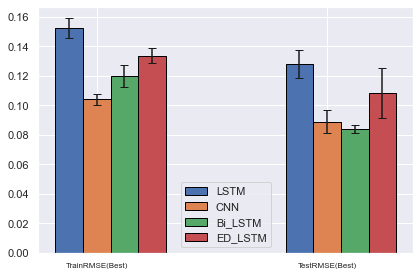

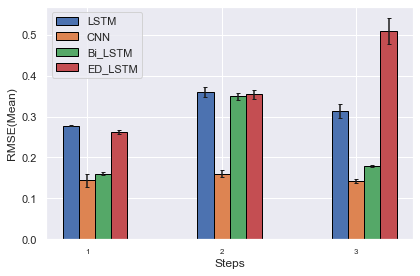

TRAIN: [32 29 23 15  8 13 30  5 14 28 22  1 12  6  4 18 21 19  9  7 31 27  3  0] TEST: [11 20 24 17  2 25 26 16 10]
Germany
(24, 5, 20)
(9, 5, 20)
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 10)                1240      
                                                                 
 dense_52 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,273
Trainable params: 1,273
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 3ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0s 2ms/s

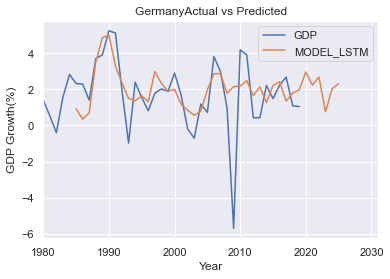

(24, 5, 20)
(9, 5, 20)
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 4, 64)             2624      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 2, 64)            0         
 g1D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 128)               0         
                                                                 
 dense_53 (Dense)            (None, 10)                1290      
                                                                 
 dense_54 (Dense)            (None, 3)                 33        
                                                                 
Total params: 3,947
Trainable params: 3,947
Non-trainable params: 0
____________________________

<Figure size 432x288 with 0 Axes>

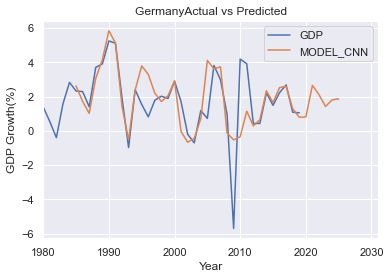

(24, 5, 20)
(9, 5, 20)
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirecti  (None, 20)               2480      
 onal)                                                           
                                                                 
 dense_55 (Dense)            (None, 3)                 63        
                                                                 
Total params: 2,543
Trainable params: 2,543
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 3ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 5 in progress
2/2 [========================

<Figure size 432x288 with 0 Axes>

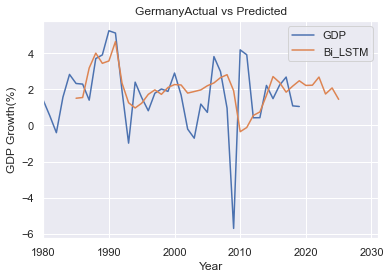

(24, 5, 20)
(9, 5, 20)
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 10)                1240      
                                                                 
 repeat_vector_10 (RepeatVec  (None, 3, 10)            0         
 tor)                                                            
                                                                 
 lstm_45 (LSTM)              (None, 3, 10)             840       
                                                                 
 time_distributed_10 (TimeDi  (None, 3, 1)             11        
 stributed)                                                      
                                                                 
Total params: 2,091
Trainable params: 2,091
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2

<Figure size 432x288 with 0 Axes>

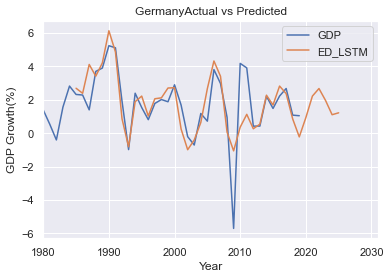

<Figure size 432x288 with 0 Axes>

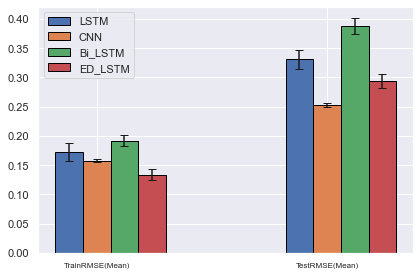

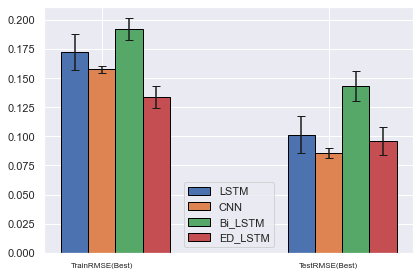

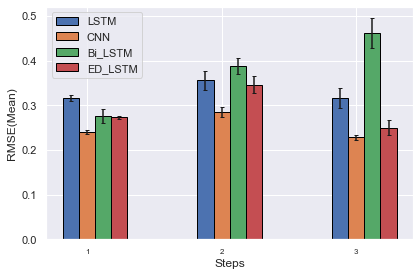

TRAIN: [32 29 23 15  8 13 30  5 14 28 22  1 12  6  4 18 21 19  9  7 31 27  3  0] TEST: [11 20 24 17  2 25 26 16 10]
India
(24, 5, 20)
(9, 5, 20)
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 10)                1240      
                                                                 
 dense_57 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,273
Trainable params: 1,273
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 3ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0s 2ms/ste

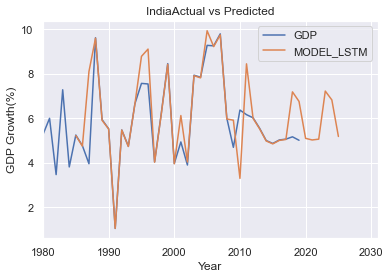

(24, 5, 20)
(9, 5, 20)
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 4, 64)             2624      
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 2, 64)            0         
 g1D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 128)               0         
                                                                 
 dense_58 (Dense)            (None, 10)                1290      
                                                                 
 dense_59 (Dense)            (None, 3)                 33        
                                                                 
Total params: 3,947
Trainable params: 3,947
Non-trainable params: 0
____________________________

<Figure size 432x288 with 0 Axes>

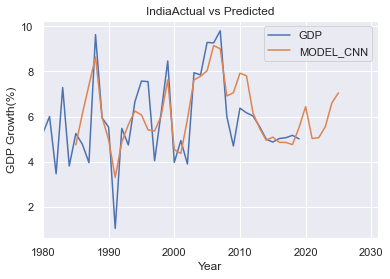

(24, 5, 20)
(9, 5, 20)
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_11 (Bidirecti  (None, 20)               2480      
 onal)                                                           
                                                                 
 dense_60 (Dense)            (None, 3)                 63        
                                                                 
Total params: 2,543
Trainable params: 2,543
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 5 in progress
2/2 [========================

<Figure size 432x288 with 0 Axes>

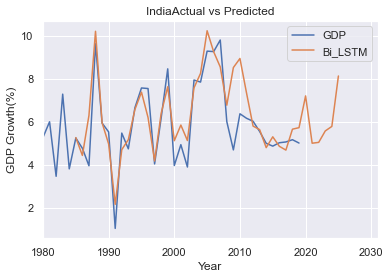

(24, 5, 20)
(9, 5, 20)
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 10)                1240      
                                                                 
 repeat_vector_11 (RepeatVec  (None, 3, 10)            0         
 tor)                                                            
                                                                 
 lstm_49 (LSTM)              (None, 3, 10)             840       
                                                                 
 time_distributed_11 (TimeDi  (None, 3, 1)             11        
 stributed)                                                      
                                                                 
Total params: 2,091
Trainable params: 2,091
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2

<Figure size 432x288 with 0 Axes>

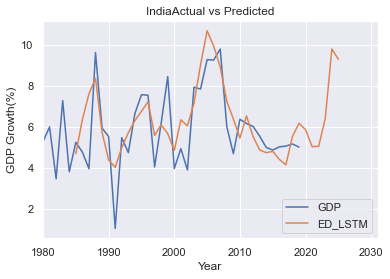

<Figure size 432x288 with 0 Axes>

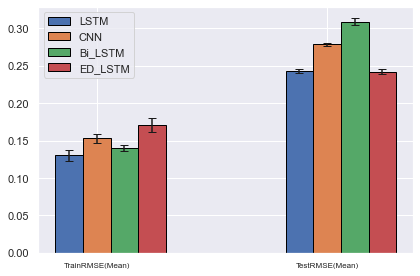

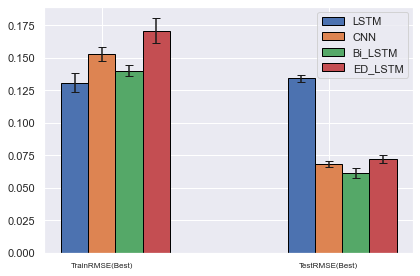

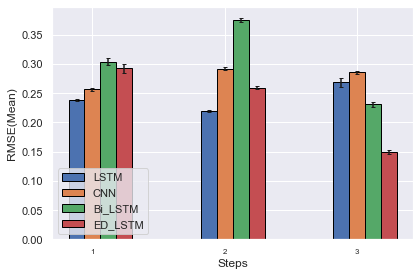

TRAIN: [32 29 23 15  8 13 30  5 14 28 22  1 12  6  4 18 21 19  9  7 31 27  3  0] TEST: [11 20 24 17  2 25 26 16 10]
Italy
(24, 5, 20)
(9, 5, 20)
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 10)                1240      
                                                                 
 dense_62 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,273
Trainable params: 1,273
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 3ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0s 2ms/ste

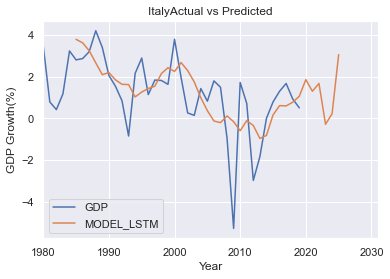

(24, 5, 20)
(9, 5, 20)
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 4, 64)             2624      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 2, 64)            0         
 g1D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 128)               0         
                                                                 
 dense_63 (Dense)            (None, 10)                1290      
                                                                 
 dense_64 (Dense)            (None, 3)                 33        
                                                                 
Total params: 3,947
Trainable params: 3,947
Non-trainable params: 0
____________________________

<Figure size 432x288 with 0 Axes>

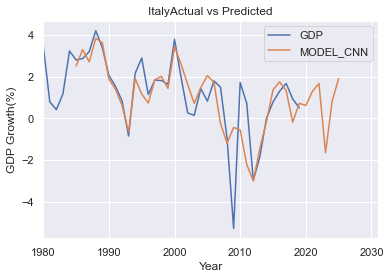

(24, 5, 20)
(9, 5, 20)
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirecti  (None, 20)               2480      
 onal)                                                           
                                                                 
 dense_65 (Dense)            (None, 3)                 63        
                                                                 
Total params: 2,543
Trainable params: 2,543
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 5 in progress
2/2 [========================

<Figure size 432x288 with 0 Axes>

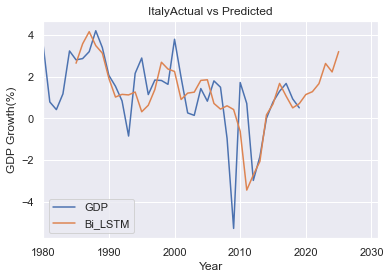

(24, 5, 20)
(9, 5, 20)
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 10)                1240      
                                                                 
 repeat_vector_12 (RepeatVec  (None, 3, 10)            0         
 tor)                                                            
                                                                 
 lstm_53 (LSTM)              (None, 3, 10)             840       
                                                                 
 time_distributed_12 (TimeDi  (None, 3, 1)             11        
 stributed)                                                      
                                                                 
Total params: 2,091
Trainable params: 2,091
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2

<Figure size 432x288 with 0 Axes>

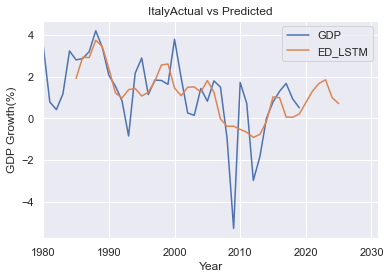

<Figure size 432x288 with 0 Axes>

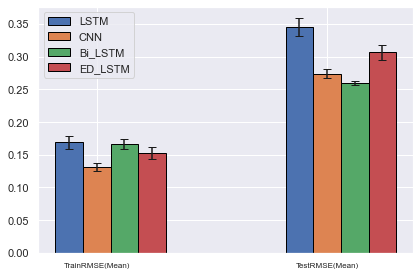

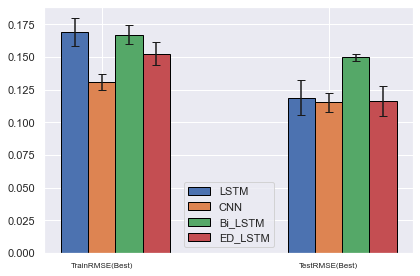

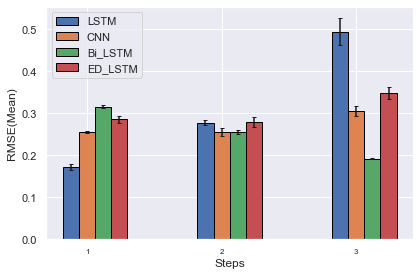

TRAIN: [32 29 23 15  8 13 30  5 14 28 22  1 12  6  4 18 21 19  9  7 31 27  3  0] TEST: [11 20 24 17  2 25 26 16 10]
Japan
(24, 5, 20)
(9, 5, 20)
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 10)                1240      
                                                                 
 dense_67 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,273
Trainable params: 1,273
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0s 2ms/ste

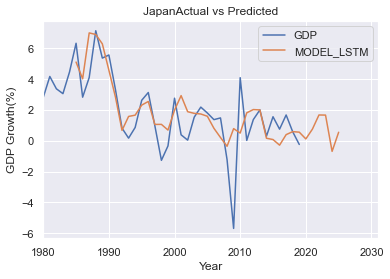

(24, 5, 20)
(9, 5, 20)
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 4, 64)             2624      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 2, 64)            0         
 g1D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 128)               0         
                                                                 
 dense_68 (Dense)            (None, 10)                1290      
                                                                 
 dense_69 (Dense)            (None, 3)                 33        
                                                                 
Total params: 3,947
Trainable params: 3,947
Non-trainable params: 0
____________________________

<Figure size 432x288 with 0 Axes>

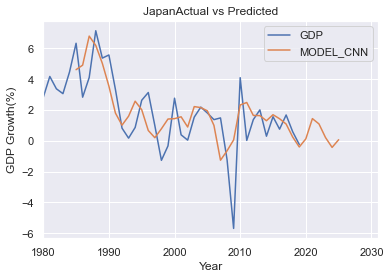

(24, 5, 20)
(9, 5, 20)
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_13 (Bidirecti  (None, 20)               2480      
 onal)                                                           
                                                                 
 dense_70 (Dense)            (None, 3)                 63        
                                                                 
Total params: 2,543
Trainable params: 2,543
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 5 in progress
2/2 [========================

<Figure size 432x288 with 0 Axes>

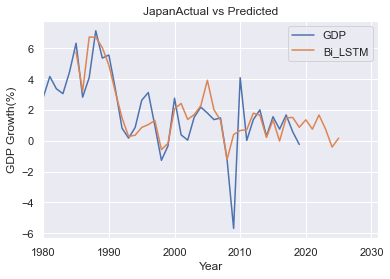

(24, 5, 20)
(9, 5, 20)
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 10)                1240      
                                                                 
 repeat_vector_13 (RepeatVec  (None, 3, 10)            0         
 tor)                                                            
                                                                 
 lstm_57 (LSTM)              (None, 3, 10)             840       
                                                                 
 time_distributed_13 (TimeDi  (None, 3, 1)             11        
 stributed)                                                      
                                                                 
Total params: 2,091
Trainable params: 2,091
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2

<Figure size 432x288 with 0 Axes>

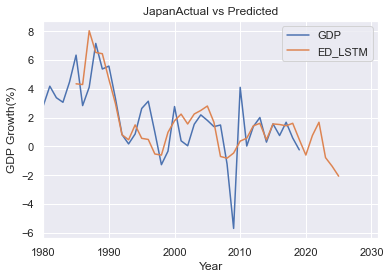

<Figure size 432x288 with 0 Axes>

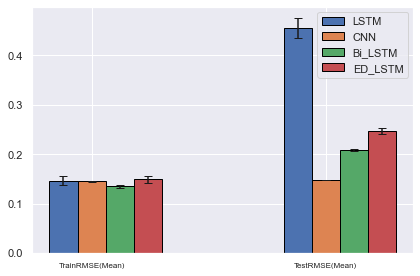

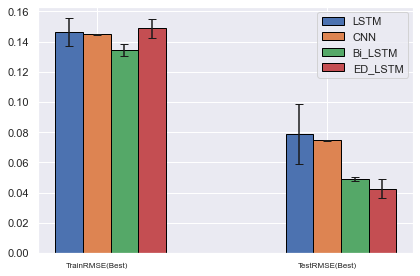

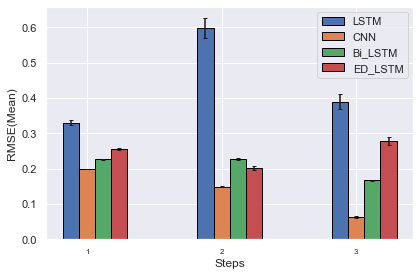

TRAIN: [11 19  8  6 16  4  2  5 17  9  7 18  3  0 15 12] TEST: [20 10 14 13  1 21]
Russia
(16, 5, 20)
(6, 5, 20)
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 10)                1240      
                                                                 
 dense_72 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,273
Trainable params: 1,273
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
1/1 [==============================] - 0s 21ms/step
Experiment 2 in progress
1/1 [==============================] - 0s 20ms/step
Experiment 3 in progress
1/1 [==============================] - 0s 20ms/step
Experiment 4 in progress
1/1 [==============================] - 0s 19ms/step
Experiment 5 in progress
1

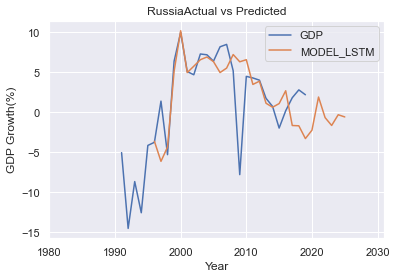

(16, 5, 20)
(6, 5, 20)
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 4, 64)             2624      
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 2, 64)            0         
 g1D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 128)               0         
                                                                 
 dense_73 (Dense)            (None, 10)                1290      
                                                                 
 dense_74 (Dense)            (None, 3)                 33        
                                                                 
Total params: 3,947
Trainable params: 3,947
Non-trainable params: 0
____________________________

<Figure size 432x288 with 0 Axes>

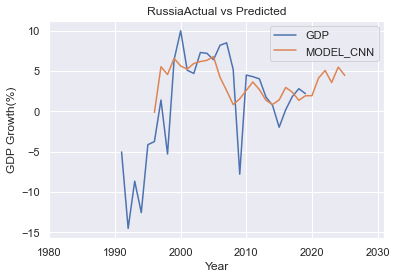

(16, 5, 20)
(6, 5, 20)
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_14 (Bidirecti  (None, 20)               2480      
 onal)                                                           
                                                                 
 dense_75 (Dense)            (None, 3)                 63        
                                                                 
Total params: 2,543
Trainable params: 2,543
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
1/1 [==============================] - 0s 20ms/step
Experiment 2 in progress
1/1 [==============================] - 0s 20ms/step
Experiment 3 in progress
1/1 [==============================] - 0s 21ms/step
Experiment 4 in progress
1/1 [==============================] - 0s 20ms/step
Experiment 5 in progress
1/1 [====================

<Figure size 432x288 with 0 Axes>

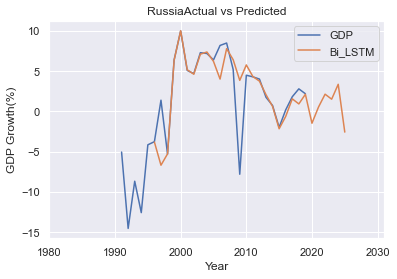

(16, 5, 20)
(6, 5, 20)
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 10)                1240      
                                                                 
 repeat_vector_14 (RepeatVec  (None, 3, 10)            0         
 tor)                                                            
                                                                 
 lstm_61 (LSTM)              (None, 3, 10)             840       
                                                                 
 time_distributed_14 (TimeDi  (None, 3, 1)             11        
 stributed)                                                      
                                                                 
Total params: 2,091
Trainable params: 2,091
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
1/1

<Figure size 432x288 with 0 Axes>

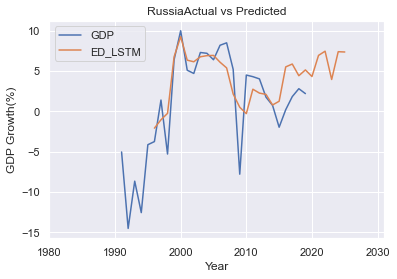

<Figure size 432x288 with 0 Axes>

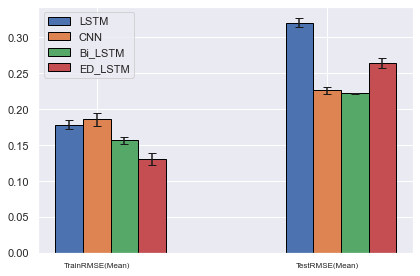

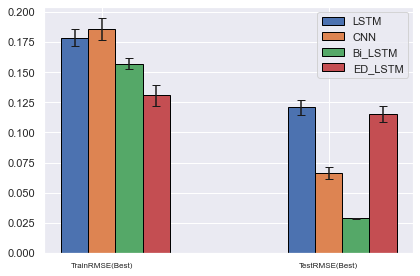

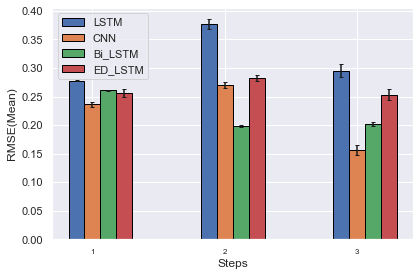

TRAIN: [32 29 23 15  8 13 30  5 14 28 22  1 12  6  4 18 21 19  9  7 31 27  3  0] TEST: [11 20 24 17  2 25 26 16 10]
South Africa
(24, 5, 20)
(9, 5, 20)
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 10)                1240      
                                                                 
 dense_77 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,273
Trainable params: 1,273
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 3ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0s 

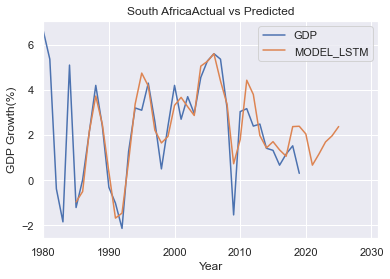

(24, 5, 20)
(9, 5, 20)
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 4, 64)             2624      
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 2, 64)            0         
 g1D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 128)               0         
                                                                 
 dense_78 (Dense)            (None, 10)                1290      
                                                                 
 dense_79 (Dense)            (None, 3)                 33        
                                                                 
Total params: 3,947
Trainable params: 3,947
Non-trainable params: 0
____________________________

<Figure size 432x288 with 0 Axes>

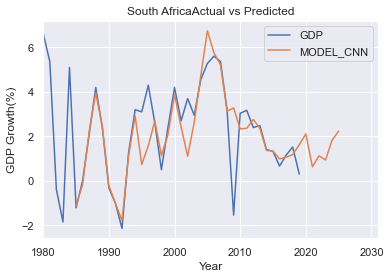

(24, 5, 20)
(9, 5, 20)
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_15 (Bidirecti  (None, 20)               2480      
 onal)                                                           
                                                                 
 dense_80 (Dense)            (None, 3)                 63        
                                                                 
Total params: 2,543
Trainable params: 2,543
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 5 in progress
2/2 [========================

<Figure size 432x288 with 0 Axes>

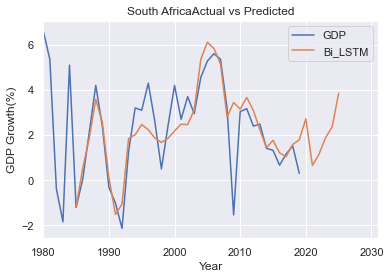

(24, 5, 20)
(9, 5, 20)
Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 10)                1240      
                                                                 
 repeat_vector_15 (RepeatVec  (None, 3, 10)            0         
 tor)                                                            
                                                                 
 lstm_65 (LSTM)              (None, 3, 10)             840       
                                                                 
 time_distributed_15 (TimeDi  (None, 3, 1)             11        
 stributed)                                                      
                                                                 
Total params: 2,091
Trainable params: 2,091
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2

<Figure size 432x288 with 0 Axes>

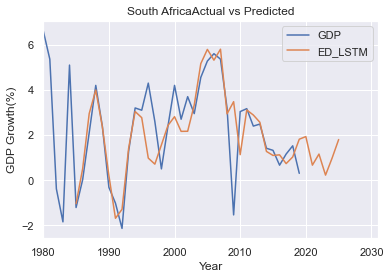

<Figure size 432x288 with 0 Axes>

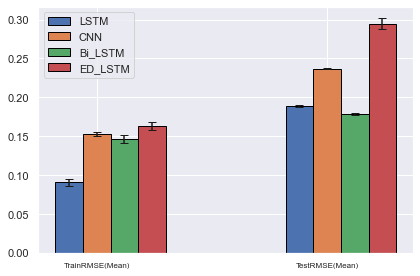

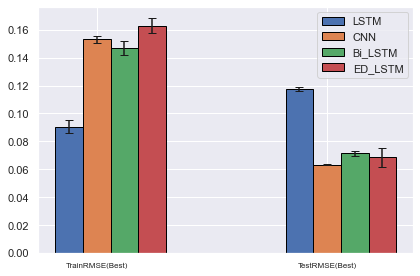

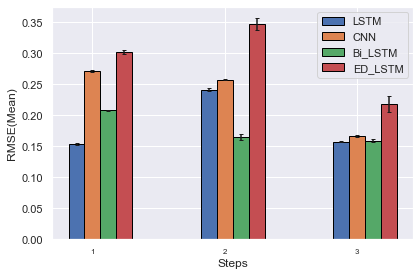

TRAIN: [32 29 23 15  8 13 30  5 14 28 22  1 12  6  4 18 21 19  9  7 31 27  3  0] TEST: [11 20 24 17  2 25 26 16 10]
United Kingdom
(24, 5, 20)
(9, 5, 20)
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 10)                1240      
                                                                 
 dense_82 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,273
Trainable params: 1,273
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0

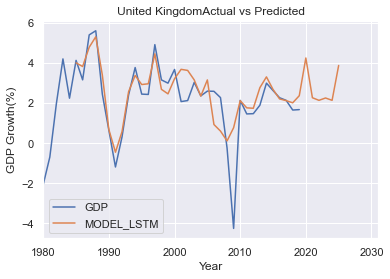

(24, 5, 20)
(9, 5, 20)
Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 4, 64)             2624      
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 2, 64)            0         
 g1D)                                                            
                                                                 
 flatten_16 (Flatten)        (None, 128)               0         
                                                                 
 dense_83 (Dense)            (None, 10)                1290      
                                                                 
 dense_84 (Dense)            (None, 3)                 33        
                                                                 
Total params: 3,947
Trainable params: 3,947
Non-trainable params: 0
____________________________

<Figure size 432x288 with 0 Axes>

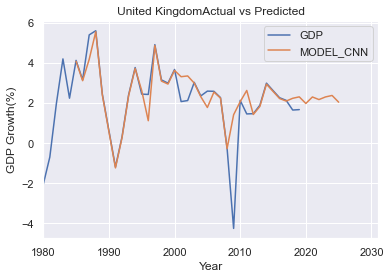

(24, 5, 20)
(9, 5, 20)
Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_16 (Bidirecti  (None, 20)               2480      
 onal)                                                           
                                                                 
 dense_85 (Dense)            (None, 3)                 63        
                                                                 
Total params: 2,543
Trainable params: 2,543
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 5 in progress
2/2 [========================

<Figure size 432x288 with 0 Axes>

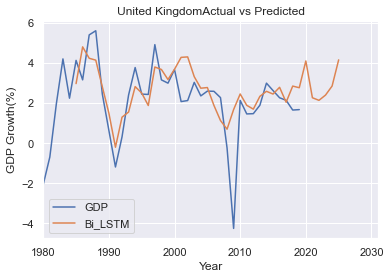

(24, 5, 20)
(9, 5, 20)
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 10)                1240      
                                                                 
 repeat_vector_16 (RepeatVec  (None, 3, 10)            0         
 tor)                                                            
                                                                 
 lstm_69 (LSTM)              (None, 3, 10)             840       
                                                                 
 time_distributed_16 (TimeDi  (None, 3, 1)             11        
 stributed)                                                      
                                                                 
Total params: 2,091
Trainable params: 2,091
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2

<Figure size 432x288 with 0 Axes>

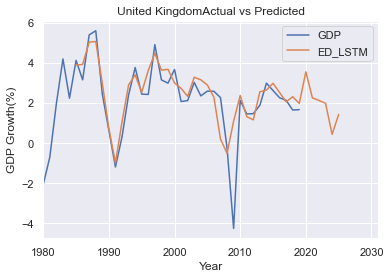

<Figure size 432x288 with 0 Axes>

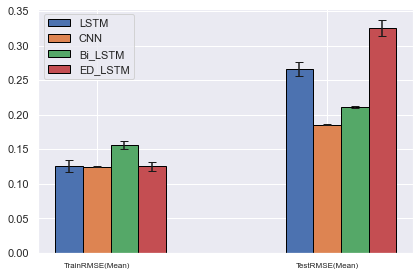

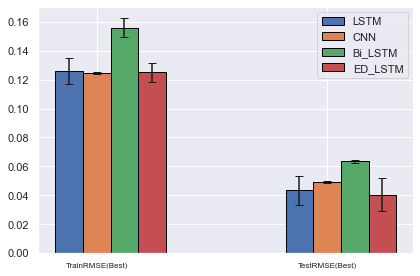

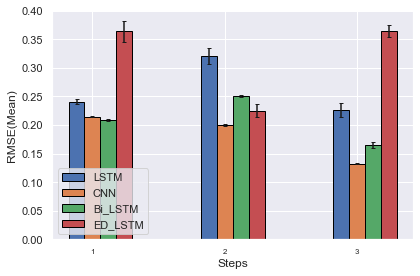

TRAIN: [32 29 23 15  8 13 30  5 14 28 22  1 12  6  4 18 21 19  9  7 31 27  3  0] TEST: [11 20 24 17  2 25 26 16 10]
United States
(24, 5, 20)
(9, 5, 20)
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 10)                1240      
                                                                 
 dense_87 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,273
Trainable params: 1,273
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0s

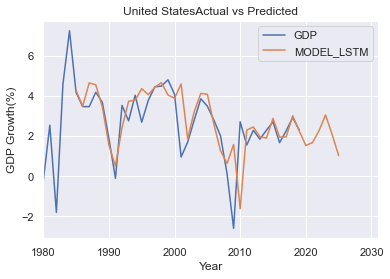

(24, 5, 20)
(9, 5, 20)
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 4, 64)             2624      
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 2, 64)            0         
 g1D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 128)               0         
                                                                 
 dense_88 (Dense)            (None, 10)                1290      
                                                                 
 dense_89 (Dense)            (None, 3)                 33        
                                                                 
Total params: 3,947
Trainable params: 3,947
Non-trainable params: 0
____________________________

<Figure size 432x288 with 0 Axes>

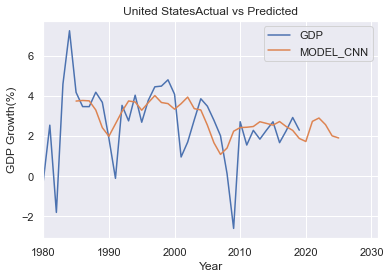

(24, 5, 20)
(9, 5, 20)
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_17 (Bidirecti  (None, 20)               2480      
 onal)                                                           
                                                                 
 dense_90 (Dense)            (None, 3)                 63        
                                                                 
Total params: 2,543
Trainable params: 2,543
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 2 in progress
2/2 [==============================] - 0s 3ms/step
Experiment 3 in progress
2/2 [==============================] - 0s 2ms/step
Experiment 4 in progress
2/2 [==============================] - 0s 4ms/step
Experiment 5 in progress
2/2 [========================

<Figure size 432x288 with 0 Axes>

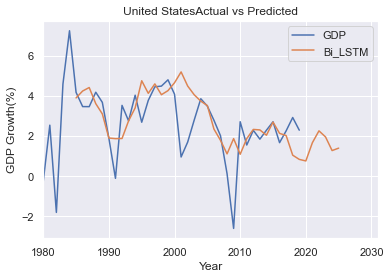

(24, 5, 20)
(9, 5, 20)
Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 10)                1240      
                                                                 
 repeat_vector_17 (RepeatVec  (None, 3, 10)            0         
 tor)                                                            
                                                                 
 lstm_73 (LSTM)              (None, 3, 10)             840       
                                                                 
 time_distributed_17 (TimeDi  (None, 3, 1)             11        
 stributed)                                                      
                                                                 
Total params: 2,091
Trainable params: 2,091
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
2/2

<Figure size 432x288 with 0 Axes>

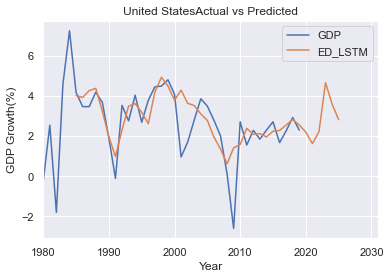

<Figure size 432x288 with 0 Axes>

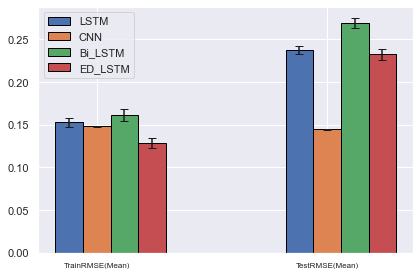

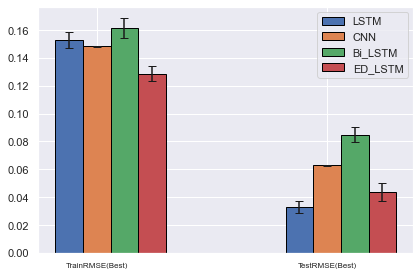

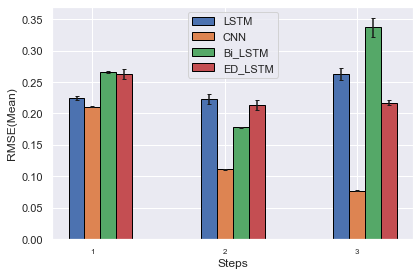

           Dataset   Method Train-RMSE-Mean Train-RMSE-Std Train-CI-LB  \
0        Australia     LSTM           0.011          0.026      0.0017   
1        Australia      CNN          0.0008         0.0012      0.0004   
2        Australia  BI_LSTM          0.0023         0.0069     -0.0002   
3        Australia  ED_LSTM           0.007         0.0185      0.0004   
4           Brazil     LSTM          0.0083         0.0231      0.0001   
5           Brazil      CNN          0.0018         0.0029      0.0008   
6           Brazil  BI_LSTM          0.0047         0.0148     -0.0006   
7           Brazil  ED_LSTM          0.0149         0.0293      0.0044   
8           Canada     LSTM          0.0059          0.016      0.0002   
9           Canada      CNN          0.0026          0.009     -0.0006   
10          Canada  BI_LSTM          0.0027         0.0108     -0.0011   
11          Canada  ED_LSTM          0.0153         0.0227      0.0072   
12           China     LSTM          0

In [21]:
if __name__ == "__main__": main()